https://towardsdatascience.com/feature-extraction-with-bert-for-text-classification-533dde44dc2f

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import sqlalchemy as sqla
df = pd.read_pickle("./dummy.pkl")

In [2]:
df

,ID_User,Beitrag
0,28526,Das ist eine Schicht von mehreren 1000 möglich...
1,28526,wird das dann wie bei den arbeitszeugnissen we...
2,28526,naja ein bisserl mehr als 10-20 prozent der be...
3,28526,Wobei ich das Beispiel der Mindestsicherung oh...
4,28526,"Also wenn es einen Narrativ in Hollywood gibt,..."
...,...,...
795,18006,"Europa zu einem ""melting pot"" zu machen mit Ku..."
796,18006,Jeder männliche Afghane ist verpflichtet einen...
797,18006,Man muss die Flüchtlinge nur bis an die türkis...
798,18006,"Nein, die islamistische Terrorgruppe ""Islamisc..."


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [4]:
LE = LabelEncoder()
df['label'] = LE.fit_transform(df['ID_User'])
df

,ID_User,Beitrag,label
0,28526,Das ist eine Schicht von mehreren 1000 möglich...,15
1,28526,wird das dann wie bei den arbeitszeugnissen we...,15
2,28526,naja ein bisserl mehr als 10-20 prozent der be...,15
3,28526,Wobei ich das Beispiel der Mindestsicherung oh...,15
4,28526,"Also wenn es einen Narrativ in Hollywood gibt,...",15
...,...,...,...
795,18006,"Europa zu einem ""melting pot"" zu machen mit Ku...",8
796,18006,Jeder männliche Afghane ist verpflichtet einen...,8
797,18006,Man muss die Flüchtlinge nur bis an die türkis...,8
798,18006,"Nein, die islamistische Terrorgruppe ""Islamisc...",8


In [5]:
import torch
from transformers import AutoTokenizer, AutoModel

device = torch.device('cpu')

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-german-cased")
model = AutoModel.from_pretrained("distilbert-base-german-cased").to(device)

Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [7]:
%%capture --no-stdout

tokenized_train = tokenizer(df_train["Beitrag"].values.tolist(), padding = True, truncation = True, return_tensors="pt")
tokenized_test = tokenizer(df_test["Beitrag"].values.tolist() , padding = True, truncation = True,  return_tensors="pt")

print(tokenized_train.keys())

tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
tokenized_test = {k:torch.tensor(v).to(device) for k,v in tokenized_test.items()}

dict_keys(['input_ids', 'attention_mask'])


In [8]:
with torch.no_grad():
  hidden_train = model(**tokenized_train) #dim : [batch_size(nr_sentences), tokens, emb_dim]
  hidden_test = model(**tokenized_test)

#get only the [CLS] hidden states
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_test = hidden_test.last_hidden_state[:,0,:]

In [9]:
x_train = cls_train.to("cpu")
y_train = df_train["label"]

x_test = cls_test.to("cpu")
y_test = df_test["label"]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([640, 768]) (640,) torch.Size([160, 768]) (160,)


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import *

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
precision = round(precision_score(y_test, y_pred, average='macro', zero_division=0) * 100, 2)
recall = round(recall_score(y_test, y_pred, average='macro') * 100, 2)
fscore = round(f1_score(y_test, y_pred, average='macro') * 100, 2)
df = pd.DataFrame(model.predict_proba(x_test), columns=model.classes_, index=y_test)
matrix = (confusion_matrix(y_test, y_pred))

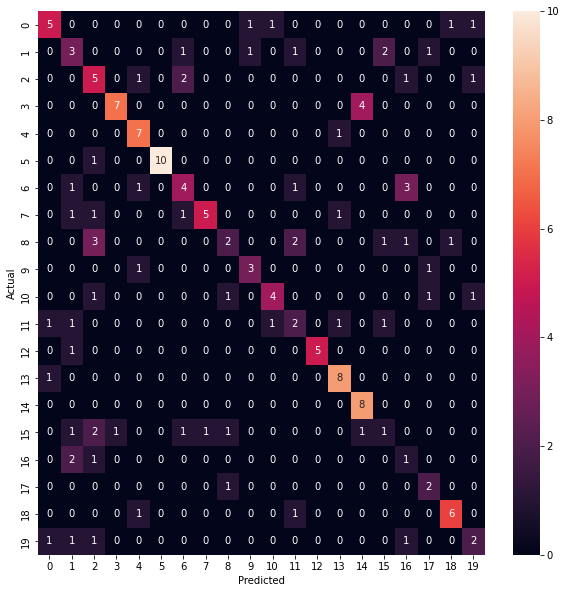

In [15]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(matrix, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
bottom, top = ax.get_ylim()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
print("Test Accuracy: %.2f\nTest Precision: %.2f\nTest Recall: %.2f\nTest Fscore: %.2f" % (
        accuracy, precision, recall, fscore))

Test Accuracy: 56.25
Test Precision: 56.04
Test Recall: 55.92
Test Fscore: 54.68
